# Session-Based Recommendation Analysis

This notebook analyzes the rental product data to prepare for a session-based next-item prediction task.
We will:
1. Load the raw hits and visits data.
2. Reconstruct user sessions.
3. Filter for product interactions.
4. Prepare the data for a sequential model (like GRU4Rec or SASRec).

## 1. Load Data
We'll load a sample of the data to understand the structure. The files are large, so we'll read the first 100,000 rows for this analysis.

In [2]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt



In [3]:
# Load ALL hits and visits
# We use low_memory=False to handle mixed types in some columns without warnings
hits_df = pd.read_csv('data/metrika_hits.csv', low_memory=False)
visits_df = pd.read_csv('data/metrika_visits.csv', low_memory=False)

print(f"Hits shape: {hits_df.shape}")
print(f"Visits shape: {visits_df.shape}")

display(hits_df.head(3))
display(visits_df.head(3))

Hits shape: (1721596, 40)
Visits shape: (323241, 26)


,project_id,watch_id,date_time,client_id,counter_user_id_hash,ip_address,region_country,region_city,page_view_id,url,...,messenger,device_category,mobile_phone,mobile_phone_model,operating_system_root,operating_system,browser,browser_major_version,screen_width,screen_height
0,1,6973243044410425541,2021-11-24T00:06:51,1634151122478355093,18267426820867536905,109.252.139.xxx,Russia,Moscow,366695459,https://oldsite.info/igrovoy-derevyannyy-stoli...,...,NaN,2,xiaomi,MI 11,android,android_11,chromemobile,96,412,915
1,1,6973278612329332737,2021-11-24T00:09:06,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,572475715,https://oldsite.info/?fbclid=PAAabmh91Sd00ZtFJ...,...,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760
2,1,6973278677122940929,2021-11-24T00:09:07,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,572475715,https://oldsite.info/?fbclid=PAAabmh91Sd00ZtFJ...,...,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760


,project_id,visit_id,date_time,is_new_user,client_id,counter_user_id_hash,ip_address,region_country,region_city,watch_ids,...,messenger,device_category,mobile_phone,mobile_phone_model,operating_system_root,operating_system,browser,browser_major_version,screen_width,screen_height
0,1,6973243044410425541,2021-11-24T00:06:51,1,1634151122478355093,18267426820867536905,109.252.139.xxx,Russia,Moscow,"[""6973243044410425541""]",...,NaN,2,xiaomi,MI 11,android,android_11,chromemobile,96,412,915
1,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",...,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760
2,1,6973290657811267695,2021-11-24T00:09:52,0,1576773326761256435,14068678113715277257,178.66.158.xxx,Russia,Saint Petersburg,"[""6973290657811267695"",""6973290679046504606"",""...",...,NaN,1,NaN,NaN,gnu_linux,linux,chrome,95,1920,1080


## 2. Reconstruct Sessions
The `metrika_visits.csv` file contains a `watch_ids` column which is a list of `watch_id`s from `metrika_hits.csv` that belong to the same session.
We need to:
1. Parse the `watch_ids` string into a list.
2. Explode the `visits_df` so each row is a single hit in a session.
3. Join with `hits_df` to get the product information for each hit.

In [4]:
# Parse watch_ids
import ast

def parse_watch_ids(x):
    try:
        return ast.literal_eval(x)
    except:
        return []

visits_df['watch_ids_list'] = visits_df['watch_ids'].apply(parse_watch_ids)

# Explode to get one row per hit in the session
session_hits = visits_df.explode('watch_ids_list').rename(columns={'watch_ids_list': 'watch_id'})

# Convert watch_id to string to ensure matching types
session_hits['watch_id'] = session_hits['watch_id'].astype(str)
hits_df['watch_id'] = hits_df['watch_id'].astype(str)

# Merge with hits to get product info
# We use inner join to keep only hits where we have details
full_session_data = session_hits.merge(hits_df, on='watch_id', how='inner')

print(f"Merged data shape: {full_session_data.shape}")
full_session_data.head()

Merged data shape: (1499141, 66)


,project_id_x,visit_id,date_time_x,is_new_user,client_id_x,counter_user_id_hash_x,ip_address_x,region_country_x,region_city_x,watch_ids,...,messenger_y,device_category_y,mobile_phone_y,mobile_phone_model_y,operating_system_root_y,operating_system_y,browser_y,browser_major_version_y,screen_width_y,screen_height_y
0,1,6973243044410425541,2021-11-24T00:06:51,1,1634151122478355093,18267426820867536905,109.252.139.xxx,Russia,Moscow,"[""6973243044410425541""]",...,NaN,2,xiaomi,MI 11,android,android_11,chromemobile,96,412,915
1,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",...,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760
2,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",...,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760
3,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",...,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760
4,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",...,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760


In [6]:
full_session_data.head(3)

,project_id_x,visit_id,date_time_x,is_new_user,client_id_x,counter_user_id_hash_x,ip_address_x,region_country_x,region_city_x,watch_ids,...,messenger_y,device_category_y,mobile_phone_y,mobile_phone_model_y,operating_system_root_y,operating_system_y,browser_y,browser_major_version_y,screen_width_y,screen_height_y
0,1,6973243044410425541,2021-11-24T00:06:51,1,1634151122478355093,18267426820867536905,109.252.139.xxx,Russia,Moscow,"[""6973243044410425541""]",...,NaN,2,xiaomi,MI 11,android,android_11,chromemobile,96,412,915
1,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",...,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760
2,1,6973278612329332737,2021-11-24T00:09:06,1,16377017461036138057,6751399865928260293,2a00:1fa1:43fe:c365::xxx,Russia,NaN,"[""6973278612329332737"",""6973278677122940929"",""...",...,NaN,2,oppo,CPH1803,android,android_oreo81,android_browser,8,360,760


## 3. Filter for Product Interactions
We are interested in predicting the next *product* page. So we filter for `page_type == 'PRODUCT'`.
We also need to sort the interactions within each session by time.

In [7]:
# Filter for products
product_interactions = full_session_data[full_session_data['page_type'] == 'PRODUCT'].copy()

# Sort by time
# Use format='mixed' to handle inconsistent datetime formats (e.g. missing seconds)
product_interactions['date_time_x'] = pd.to_datetime(product_interactions['date_time_x'])
product_interactions = product_interactions.sort_values(['visit_id', 'date_time_x'])

# Group by session to get sequences
session_sequences = product_interactions.groupby('visit_id')['url'].apply(list).reset_index()

# Filter out sessions with only 1 item (nothing to predict)
session_sequences = session_sequences[session_sequences['url'].apply(len) > 1]

print(f"Number of valid product sessions: {len(session_sequences)}")
session_sequences.head()

Number of valid product sessions: 86970


,visit_id,url
2,714740689010850,"[https://oldsite.info/piratskiy-korabl-elc, ht..."
4,888778575315222,[https://oldsite.info/kolyaska-progulochnaya-s...
6,1772575692947650,[https://oldsite.info/elektronnye-kacheli-mama...
8,2716922663403638,"[https://oldsite.info/shezlong-jetem-relax, ht..."
9,2731618072002643,"[https://oldsite.info/avtokreslo-sparco-f500k,..."


## 3.6 Sequence Statistics
Let's look at the distribution of session lengths to decide on a padding length.

In [9]:
# Load mapping files
old_products = pd.read_csv('data/old_site_products.csv', usecols=['id', 'slug'])
old_to_new = pd.read_csv('data/old_site_new_site_products.csv')
new_products = pd.read_csv('data/new_site_products.csv', usecols=['id', 'slug'])

# Create Old Slug -> Old ID map
old_slug_map = dict(zip(old_products['slug'], old_products['id']))

# Create Old ID -> New ID map
old_id_to_new_id_map = dict(zip(old_to_new['old_site_id'], old_to_new['new_site_id']))

# Create New Slug -> New ID map
new_slug_map = dict(zip(new_products['slug'], new_products['id']))

# Unified Map Function
def get_product_id(slug):
    # Ensure slug is a string
    if not isinstance(slug, str):
        return None
        
    # Try direct new site map
    if slug in new_slug_map:
        return new_slug_map[slug]
    
    # Try old site path: Slug -> Old ID -> New ID
    if slug in old_slug_map:
        old_id = old_slug_map[slug]
        if old_id in old_id_to_new_id_map:
            return old_id_to_new_id_map[old_id]
            
    return None

# Apply mapping
# We apply this to the exploded 'full_session_data' before grouping, or to the sequences.
# Let's apply to 'product_interactions' dataframe from step 3.

product_interactions['product_id'] = product_interactions['slug'].apply(get_product_id)

# Drop interactions where we couldn't find a product ID
valid_interactions = product_interactions.dropna(subset=['product_id'])
valid_interactions['product_id'] = valid_interactions['product_id'].astype(int)

print(f"Original interactions: {len(product_interactions)}")
print(f"Mapped interactions: {len(valid_interactions)}")

# Re-group into sequences with IDs
final_sequences = valid_interactions.sort_values(['visit_id', 'date_time_x']).groupby('visit_id')['product_id'].apply(list).reset_index()
final_sequences = final_sequences[final_sequences['product_id'].apply(len) > 1]

print(f"Final valid sessions: {len(final_sequences)}")
final_sequences.head()

/var/folders/1z/csflksrn5b92jlcgb8lgbbfh0000gp/T/ipykernel_74460/3368941403.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_interactions['product_id'] = valid_interactions['product_id'].astype(int)


Original interactions: 408562
Mapped interactions: 331689
Final valid sessions: 73420
Final valid sessions: 73420


,visit_id,product_id
1,714740689010850,"[495513634, 495513634, 495513634]"
3,888778575315222,"[495400631, 495400631]"
5,1772575692947650,"[463480691, 463480231]"
7,2731618072002643,"[495253324, 495253324]"
8,2916239911157990,"[495519137, 495519137, 495519137]"


In [10]:
# Clean up duplicate columns from the merge
# We'll keep the _x versions (from visits/session) and drop _y (from hits) where they duplicate
cols_to_rename = {}
cols_to_drop = []

for col in valid_interactions.columns:
    if col.endswith('_x'):
        base_name = col[:-2]
        cols_to_rename[col] = base_name
        # If there's a corresponding _y, mark it for dropping
        if base_name + '_y' in valid_interactions.columns:
            cols_to_drop.append(base_name + '_y')

# Drop the _y columns
valid_interactions_clean = valid_interactions.drop(columns=cols_to_drop)

# Rename the _x columns
valid_interactions_clean = valid_interactions_clean.rename(columns=cols_to_rename)

print(f"Original shape: {valid_interactions.shape}")
print(f"Clean shape: {valid_interactions_clean.shape}")
print("Clean columns:", valid_interactions_clean.columns.tolist())


valid_interactions = valid_interactions_clean

Original shape: (331689, 67)
Clean shape: (331689, 49)
Clean columns: ['project_id', 'visit_id', 'date_time', 'is_new_user', 'client_id', 'counter_user_id_hash', 'ip_address', 'region_country', 'region_city', 'watch_ids', 'traffic_source', 'adv_engine', 'search_engine_root', 'search_engine', 'social_network', 'recommendation_system', 'messenger', 'device_category', 'mobile_phone', 'mobile_phone_model', 'operating_system_root', 'operating_system', 'browser', 'browser_major_version', 'screen_width', 'screen_height', 'watch_id', 'page_view_id', 'url', 'page_type', 'slug', 'cart_id', 'order_number', 'exists_in_cart_table', 'artificial', 'is_page_view', 'not_bounce', 'ecommerce', 'link', 'download', 'params', 'goals_id', 'last_traffic_source', 'last_search_engine_root', 'last_search_engine', 'last_adv_engine', 'last_social_network', 'last_social_network_profile', 'product_id']


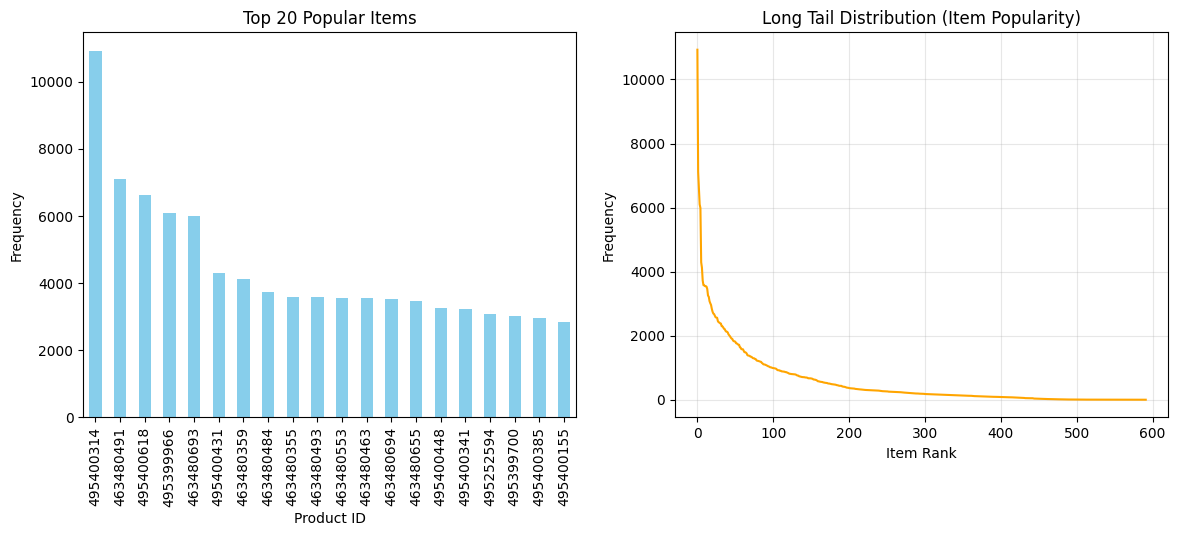

Total unique items: 592
Top 1% (5 items) account for 11.08% of all interactions.


In [12]:
# 3.7 Deep Dive EDA
import seaborn as sns

# 1. Item Popularity Analysis
# Check for Long Tail distribution
item_counts = valid_interactions['product_id'].value_counts()

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
item_counts.head(20).plot(kind='bar', color='skyblue')
plt.title('Top 20 Popular Items')
plt.xlabel('Product ID')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.plot(item_counts.values, color='orange')
plt.title('Long Tail Distribution (Item Popularity)')
plt.xlabel('Item Rank')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

top_1_percent = int(len(item_counts) * 0.01)
share = item_counts.head(top_1_percent).sum() / item_counts.sum()
print(f"Total unique items: {len(item_counts)}")
print(f"Top 1% ({top_1_percent} items) account for {share:.2%} of all interactions.")

/var/folders/1z/csflksrn5b92jlcgb8lgbbfh0000gp/T/ipykernel_2547/3341243589.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='hour', data=valid_interactions, palette='viridis')
/var/folders/1z/csflksrn5b92jlcgb8lgbbfh0000gp/T/ipykernel_2547/3341243589.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=valid_interactions, order=days_order, palette='magma')
/var/folders/1z/csflksrn5b92jlcgb8lgbbfh0000gp/T/ipykernel_2547/3341243589.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='day_of_week', data=valid

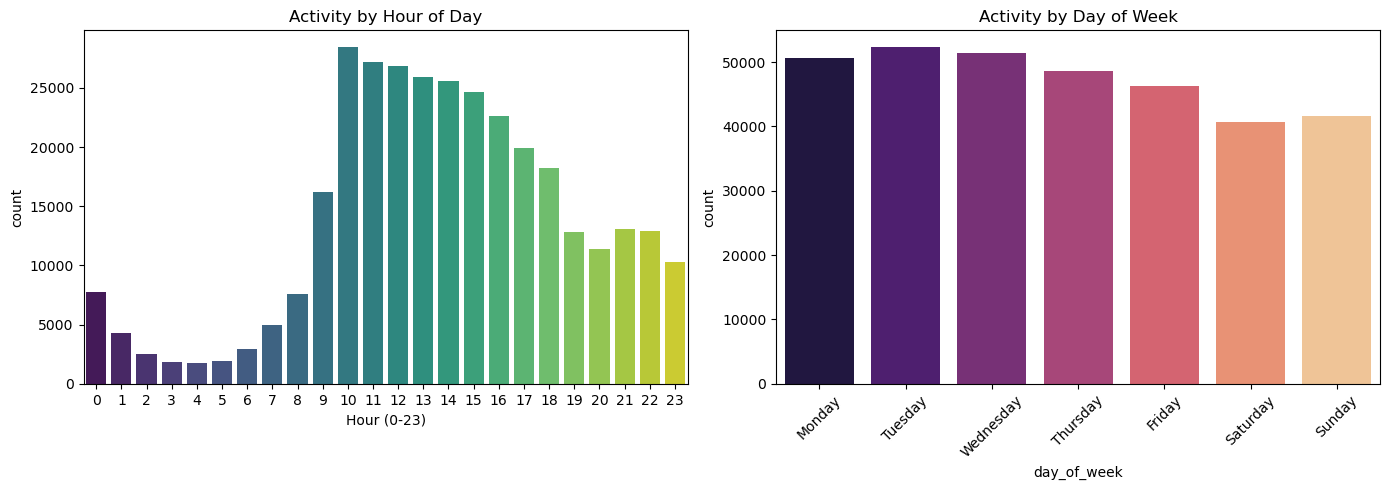

In [59]:
# 2. Temporal Analysis
# Extract hour and day
valid_interactions['hour'] = valid_interactions['date_time'].dt.hour
valid_interactions['day_of_week'] = valid_interactions['date_time'].dt.day_name()

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='hour', data=valid_interactions, palette='viridis')
plt.title('Activity by Hour of Day')
plt.xlabel('Hour (0-23)')

plt.subplot(1, 2, 2)
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x='day_of_week', data=valid_interactions, order=days_order, palette='magma')
plt.title('Activity by Day of Week')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

/var/folders/1z/csflksrn5b92jlcgb8lgbbfh0000gp/T/ipykernel_2547/2175800395.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=source_counts.index, y=source_counts.values, palette='coolwarm')
/var/folders/1z/csflksrn5b92jlcgb8lgbbfh0000gp/T/ipykernel_2547/2175800395.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='traffic_source', y='session_length', data=session_lengths_df, palette='coolwarm')


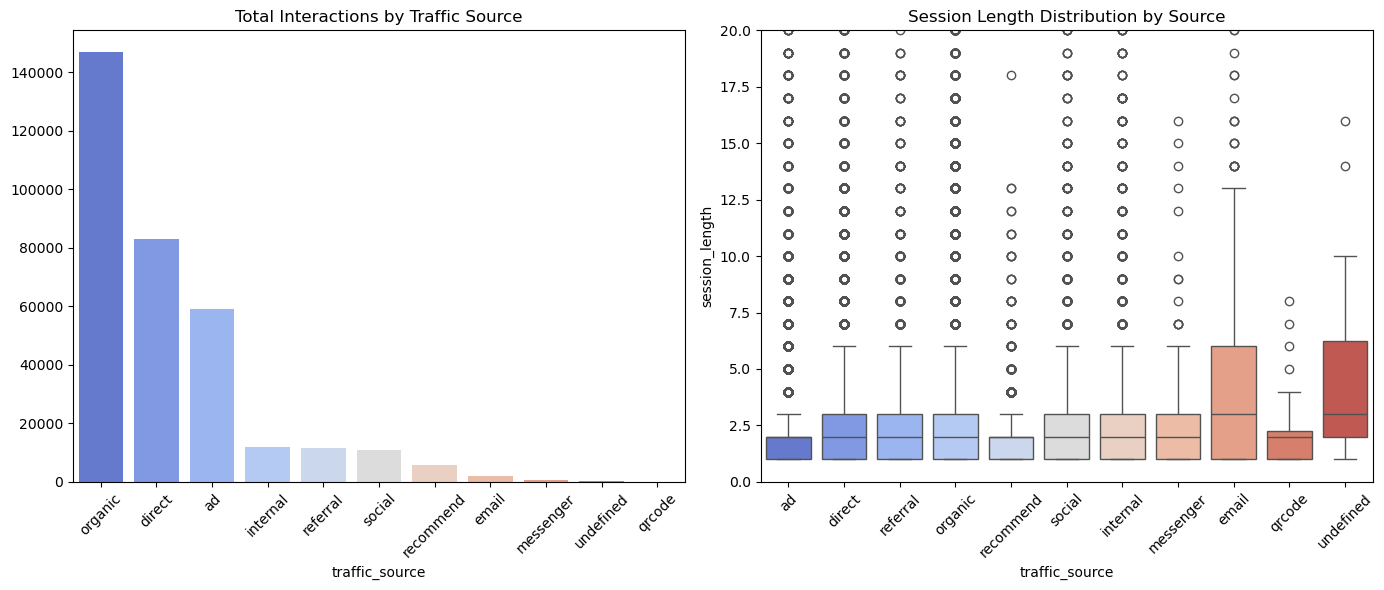

In [60]:
# 3. Traffic Source Analysis
# Merge with visits to get traffic source if not already present
if 'traffic_source' not in valid_interactions.columns:
    # We need to be careful with duplicates in visits_df, so we take unique visit_id -> traffic_source
    visit_source_map = visits_df[['visit_id', 'traffic_source']].drop_duplicates('visit_id')
    valid_interactions = valid_interactions.merge(visit_source_map, on='visit_id', how='left')

plt.figure(figsize=(14, 6))

# Count of interactions by source
plt.subplot(1, 2, 1)
source_counts = valid_interactions['traffic_source'].value_counts()
sns.barplot(x=source_counts.index, y=source_counts.values, palette='coolwarm')
plt.title('Total Interactions by Traffic Source')
plt.xticks(rotation=45)

# Session Length by Source
# Calculate length per session first
session_lengths_df = valid_interactions.groupby(['visit_id', 'traffic_source']).size().reset_index(name='session_length')

plt.subplot(1, 2, 2)
sns.boxplot(x='traffic_source', y='session_length', data=session_lengths_df, palette='coolwarm')
plt.ylim(0, 20) # Zoom in to see the box bodies
plt.title('Session Length Distribution by Source')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Average sessions per user: 1.54
Max sessions for a user: 4094
Users with > 1 session: 14026 (18.05%)


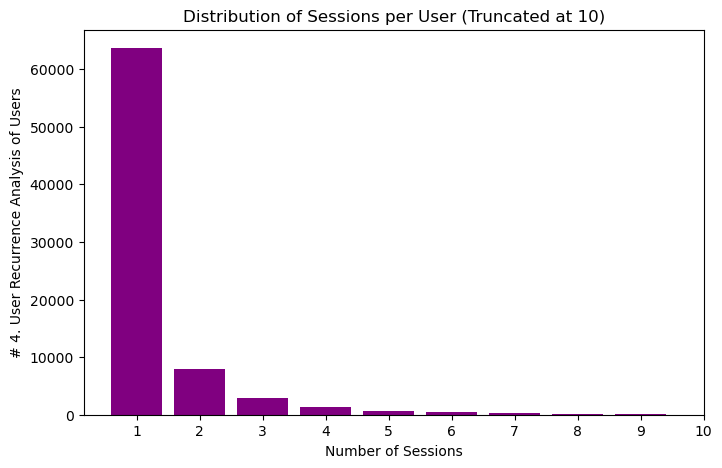

In [61]:
# 4. User Recurrence Analysis

# 1. Fix Duplicate Columns (The Safety Check)
# This keeps the first occurrence of a column name and drops subsequent duplicates
valid_interactions = valid_interactions.loc[:, ~valid_interactions.columns.duplicated()]

# 2. Merge with visits to get client_id if it's truly missing
if 'client_id' not in valid_interactions.columns:
    visit_client_map = visits_df[['visit_id', 'client_id']].drop_duplicates('visit_id')
    valid_interactions = valid_interactions.merge(visit_client_map, on='visit_id', how='left')

# 3. Perform Analysis
sessions_per_user = valid_interactions.groupby('client_id')['visit_id'].nunique()

print(f"Average sessions per user: {sessions_per_user.mean():.2f}")
print(f"Max sessions for a user: {sessions_per_user.max()}")
print(f"Users with > 1 session: {(sessions_per_user > 1).sum()} ({((sessions_per_user > 1).sum() / len(sessions_per_user)):.2%})")

plt.figure(figsize=(8, 5))
# Filter for users with < 10 sessions for readability
plt.hist(sessions_per_user[sessions_per_user < 10], bins=range(1, 11), align='left', rwidth=0.8, color='purple')
plt.title('Distribution of Sessions per User (Truncated at 10)')
plt.xlabel('Number of Sessions')
plt.ylabel('# 4. User Recurrence Analysis of Users')

plt.xticks(range(1, 11))
plt.show()


# Feature Engineering

In [15]:
# 4.1 Feature Engineering with NVTabular
import nvtabular as nvt
from nvtabular.ops import *
from merlin.schema.tags import Tags
import shutil
import os

# 0. Ensure Derived Features Exist
# We need to make sure 'hour' and 'day_of_week' are present before creating the NVTabular dataset.
# These might have been created in the EDA section, but let's ensure they are here.
if 'hour' not in valid_interactions.columns:
    valid_interactions['hour'] = valid_interactions['date_time'].dt.hour
if 'day_of_week' not in valid_interactions.columns:
    valid_interactions['day_of_week'] = valid_interactions['date_time'].dt.day_name()

# 1. Prepare DataFrame for NVTabular
# T4Rec expects 'item_id', so let's rename product_id
# We use the 'valid_interactions' dataframe you created in Step 3
nvt_df = valid_interactions.rename(columns={'product_id': 'item_id'}).copy()

# CRITICAL FIX: Reset Index to ensure clean RangeIndex for NVTabular
# This prevents "IndexError: index out of bounds" during Categorify
nvt_df = nvt_df.reset_index(drop=True)

# Ensure types
nvt_df['visit_id'] = nvt_df['visit_id'].astype(str)
nvt_df['item_id'] = nvt_df['item_id'].astype(int)

# 2. Define Features
# We use the same categorical features you selected
categorical_features = [
    'region_country', 'region_city', 
    'traffic_source', 'adv_engine', 'search_engine', 
    'social_network', 'recommendation_system', 'messenger', 
    'operating_system', 'device_category',
    'browser', 'day_of_week', 'hour'
]

# 3. Define NVTabular Pipeline
# Item ID: Categorify and Tag
item_id = ['item_id'] >> Categorify(dtype="int64") >> TagAsItemID()

# Context Features: Categorify
context_features = categorical_features >> Categorify(dtype="int64")

# Session ID: Categorify and Tag
session_id = ['visit_id'] >> Categorify(dtype="int64") >> TagAsUserID()

# Time
time_col = ['date_time']

# Grouping (Create Sequences)
# This replaces your manual groupby logic
groupby_features = (
    session_id + item_id + context_features + time_col
) >> Groupby(
    groupby_cols=['visit_id'],
    sort_cols=['date_time'],
    aggs={
        'item_id': 'list',
        'date_time': 'first',
        **{feat: 'list' for feat in categorical_features}
    },
    name_sep="-"
)

# 4. Execute Workflow
workflow = nvt.Workflow(groupby_features)
dataset = nvt.Dataset(nvt_df)

# Clean up previous runs
if os.path.exists("data/processed_nvt"):
    shutil.rmtree("data/processed_nvt")

print("Fitting and transforming with NVTabular...")
workflow.fit(dataset)
workflow.transform(dataset).to_parquet("data/processed_nvt")

print("NVTabular processing complete. Data saved to 'data/processed_nvt'.")

/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Fitting and transforming with NVTabular...


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


NVTabular processing complete. Data saved to 'data/processed_nvt'.


## 4. Data Preparation for PyTorch
We need to:
1.  Map Product IDs to integer indices (0 to N-1).
2.  Create `(input, target)` pairs.
    *   Input: `[Item1, Item2]`
    *   Target: `Item3`
3.  Split into Train/Validation.

In [16]:
# 4. Data Preparation for T4Rec
import merlin.io
import glob

# Load the processed data
processed_path = "data/processed_nvt"

# Load as DataFrame to perform time-based split
# (We do this to maintain the strict temporal split you wanted)
parquet_files = glob.glob(os.path.join(processed_path, "*.parquet"))
df = pd.read_parquet(parquet_files)
df = df.sort_values('date_time-first')

# 80/20 Time Split
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
valid_df = df.iloc[split_index:]

# Save split files for T4Rec
train_df.to_parquet("data/train.parquet")
valid_df.to_parquet("data/valid.parquet")

print(f"Train sessions: {len(train_df)}")
print(f"Valid sessions: {len(valid_df)}")

Train sessions: 95533
Valid sessions: 23884


## 5. Model Definition (GRU)
We'll use a simple GRU model:
- **Embedding Layer**: Converts item indices to dense vectors.
- **GRU Layer**: Processes the sequence.
- **Linear Head**: Predicts the next item.

In [37]:
# 5. Model Definition (Transformers4Rec)
import transformers4rec.torch as tr
from merlin.schema import Schema
import merlin.io

# Define Hyperparameters
hparams = {
    "d_model": 64,
    "n_head": 4,
    "n_layer": 2,
    "max_seq_length": 30, # Matching your analysis MAX_LEN
    "learning_rate": 0.001,
    "batch_size": 256,
    "dropout": 0.1,
}

# Load Schema from the NVTabular output directory
# This ensures we get the schema with all the tags (categorical, list, item, etc.)
# We use the directory path where NVT saved the data, NOT the pandas-saved train.parquet
train_schema = merlin.io.Dataset("data/processed_nvt", engine="parquet").schema

# Select Input Features (Item ID + Context)
# We redefine the list here to ensure it matches the NVT step
categorical_features = [
    'region_country', 'region_city', 
    'traffic_source', 'adv_engine', 'search_engine', 
    'social_network', 'recommendation_system', 'messenger', 
    'operating_system', 'device_category',
    'browser', 'day_of_week', 'hour'
]

# Note: We use the '-list' suffix NVT added
input_features = ['item_id-list'] + [f"{feat}-list" for feat in categorical_features]
input_schema = train_schema.select_by_name(input_features)

print(f"Selected {len(input_schema)} features for the model.")

# Fix Schema (Ensure value_count max matches seq length for embeddings)
new_cols = []
for col in input_schema:
    props = col.properties.copy()
    if 'value_count' not in props:
        props['value_count'] = {}
    props['value_count']['max'] = hparams["max_seq_length"]
    new_col = col.with_properties(props)
    new_cols.append(new_col)
input_schema = Schema(new_cols)

# 1. Input Block
# We keep batch_size here as a safeguard
input_module = tr.TabularSequenceFeatures.from_schema(
    input_schema,
    max_sequence_length=hparams["max_seq_length"],
    aggregation="concat",
    d_output=hparams["d_model"],
    masking="causal",
    batch_size=hparams["batch_size"] 
)

# 2. Transformer Body (GPT2 Style)
# CRITICAL FIX: Set total_seq_length higher than max_seq_length
# This prevents "IndexError: index out of range in self" in positional embeddings
transformer_config = tr.GPT2Config.build(
    d_model=hparams["d_model"],
    n_head=hparams["n_head"],
    n_layer=hparams["n_layer"],
    total_seq_length=1024, # Increased from hparams["max_seq_length"]
    dropout=hparams["dropout"],
)

body = tr.SequentialBlock(
    input_module,
    tr.TransformerBlock(transformer_config, masking=input_module.masking)
)

# 3. Prediction Head
from transformers4rec.torch.ranking_metric import NDCGAt, RecallAt
# The list [6, 10, 20] means we calculate metrics for the top-6, top-10, and top-20 predictions.
metrics = [RecallAt(top_ks=[6, 10, 20], labels_onehot=True), NDCGAt(top_ks=[6, 10, 20], labels_onehot=True)]

head = tr.Head(
    body,
    tr.NextItemPredictionTask(weight_tying=True, metrics=metrics),
    inputs=input_module,
)

model = tr.Model(head)
print(model)

/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


Selected 14 features for the model.
Model(
  (heads): ModuleList(
    (0): Head(
      (body): SequentialBlock(
        (0): TabularSequenceFeatures(
          (_aggregation): ConcatFeatures()
          (to_merge): ModuleDict(
            (categorical_module): SequenceEmbeddingFeatures(
              (filter_features): FilterFeatures()
              (embedding_tables): ModuleDict(
                (item_id-list): Embedding(595, 64, padding_idx=0)
                (region_country-list): Embedding(104, 64, padding_idx=0)
                (region_city-list): Embedding(1177, 64, padding_idx=0)
                (traffic_source-list): Embedding(14, 64, padding_idx=0)
                (adv_engine-list): Embedding(13, 64, padding_idx=0)
                (search_engine-list): Embedding(18, 64, padding_idx=0)
                (social_network-list): Embedding(7, 64, padding_idx=0)
                (recommendation_system-list): Embedding(5, 64, padding_idx=0)
                (messenger-list): Embedding(4,

In [38]:
# 6. Training Loop (T4Rec Trainer)
from transformers4rec.torch.trainer import Trainer

training_args = tr.T4RecTrainingArguments(
    output_dir="./t4r_analysis_output",
    max_steps=-1,
    num_train_epochs=8,
    learning_rate=hparams["learning_rate"],
    per_device_train_batch_size=hparams["batch_size"],
    per_device_eval_batch_size=hparams["batch_size"],
    logging_steps=100,
    eval_steps=100,
    save_steps=100,
    evaluation_strategy="steps",
    report_to=[], 
    dataloader_drop_last=False,
    compute_metrics_each_n_steps=1,
    no_cuda=True, # Force CPU for macOS stability
    use_mps_device=False, # Disable MPS to avoid "Placeholder storage" errors
    load_best_model_at_end=True,
    metric_for_best_model="eval_/loss",
    greater_is_better=False
)

# CRITICAL FIX: Use input_schema instead of train_schema
# train_schema contains 'visit_id' (string) which causes DLPack BufferError
# input_schema only contains the numeric features the model needs
trainer = Trainer(
    model=model,
    args=training_args,
    schema=input_schema, 
    train_dataset_or_path="data/train.parquet",
    eval_dataset_or_path="data/valid.parquet",
)

print("Starting T4Rec Training...")
trainer.train()

Starting T4Rec Training...


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2992 [00:00<?, ?it/s]

{'loss': 5.3531, 'learning_rate': 0.0009665775401069518, 'epoch': 0.27}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 4.926436901092529, 'eval_runtime': 3.1428, 'eval_samples_per_second': 7656.816, 'eval_steps_per_second': 29.909, 'epoch': 0.27}
{'loss': 4.3189, 'learning_rate': 0.0009331550802139037, 'epoch': 0.53}
{'loss': 4.3189, 'learning_rate': 0.0009331550802139037, 'epoch': 0.53}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 4.092318534851074, 'eval_runtime': 3.1239, 'eval_samples_per_second': 7703.081, 'eval_steps_per_second': 30.09, 'epoch': 0.53}
{'loss': 3.7748, 'learning_rate': 0.0008997326203208556, 'epoch': 0.8}
{'loss': 3.7748, 'learning_rate': 0.0008997326203208556, 'epoch': 0.8}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 3.6083452701568604, 'eval_runtime': 3.1815, 'eval_samples_per_second': 7563.802, 'eval_steps_per_second': 29.546, 'epoch': 0.8}
{'loss': 3.5149, 'learning_rate': 0.0008663101604278076, 'epoch': 1.07}
{'loss': 3.5149, 'learning_rate': 0.0008663101604278076, 'epoch': 1.07}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 3.400123119354248, 'eval_runtime': 3.1414, 'eval_samples_per_second': 7660.233, 'eval_steps_per_second': 29.923, 'epoch': 1.07}
{'loss': 3.3744, 'learning_rate': 0.0008328877005347594, 'epoch': 1.34}
{'loss': 3.3744, 'learning_rate': 0.0008328877005347594, 'epoch': 1.34}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 3.3012137413024902, 'eval_runtime': 3.3119, 'eval_samples_per_second': 7265.898, 'eval_steps_per_second': 28.382, 'epoch': 1.34}
{'loss': 3.3076, 'learning_rate': 0.0007994652406417113, 'epoch': 1.6}
{'loss': 3.3076, 'learning_rate': 0.0007994652406417113, 'epoch': 1.6}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 3.157331705093384, 'eval_runtime': 3.1915, 'eval_samples_per_second': 7540.099, 'eval_steps_per_second': 29.454, 'epoch': 1.6}
{'loss': 3.2643, 'learning_rate': 0.0007660427807486631, 'epoch': 1.87}
{'loss': 3.2643, 'learning_rate': 0.0007660427807486631, 'epoch': 1.87}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 3.081277370452881, 'eval_runtime': 3.2061, 'eval_samples_per_second': 7505.802, 'eval_steps_per_second': 29.32, 'epoch': 1.87}
{'loss': 3.1788, 'learning_rate': 0.000732620320855615, 'epoch': 2.14}
{'loss': 3.1788, 'learning_rate': 0.000732620320855615, 'epoch': 2.14}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 3.0226850509643555, 'eval_runtime': 3.2937, 'eval_samples_per_second': 7306.078, 'eval_steps_per_second': 28.539, 'epoch': 2.14}
{'loss': 3.1664, 'learning_rate': 0.0006991978609625669, 'epoch': 2.41}
{'loss': 3.1664, 'learning_rate': 0.0006991978609625669, 'epoch': 2.41}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 3.037946939468384, 'eval_runtime': 3.23, 'eval_samples_per_second': 7450.166, 'eval_steps_per_second': 29.102, 'epoch': 2.41}
{'loss': 3.1474, 'learning_rate': 0.0006657754010695187, 'epoch': 2.67}
{'loss': 3.1474, 'learning_rate': 0.0006657754010695187, 'epoch': 2.67}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 3.012246608734131, 'eval_runtime': 3.2071, 'eval_samples_per_second': 7503.441, 'eval_steps_per_second': 29.31, 'epoch': 2.67}
{'loss': 3.149, 'learning_rate': 0.0006323529411764706, 'epoch': 2.94}
{'loss': 3.149, 'learning_rate': 0.0006323529411764706, 'epoch': 2.94}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 3.028759479522705, 'eval_runtime': 3.3066, 'eval_samples_per_second': 7277.518, 'eval_steps_per_second': 28.428, 'epoch': 2.94}
{'loss': 3.0708, 'learning_rate': 0.0005989304812834224, 'epoch': 3.21}
{'loss': 3.0708, 'learning_rate': 0.0005989304812834224, 'epoch': 3.21}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9777615070343018, 'eval_runtime': 3.3713, 'eval_samples_per_second': 7137.829, 'eval_steps_per_second': 27.882, 'epoch': 3.21}
{'loss': 3.1019, 'learning_rate': 0.0005655080213903744, 'epoch': 3.48}
{'loss': 3.1019, 'learning_rate': 0.0005655080213903744, 'epoch': 3.48}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9915738105773926, 'eval_runtime': 3.2718, 'eval_samples_per_second': 7354.907, 'eval_steps_per_second': 28.73, 'epoch': 3.48}
{'loss': 3.0817, 'learning_rate': 0.0005320855614973262, 'epoch': 3.74}
{'loss': 3.0817, 'learning_rate': 0.0005320855614973262, 'epoch': 3.74}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 3.000110387802124, 'eval_runtime': 3.1933, 'eval_samples_per_second': 7535.665, 'eval_steps_per_second': 29.436, 'epoch': 3.74}
{'loss': 3.0711, 'learning_rate': 0.000498663101604278, 'epoch': 4.01}
{'loss': 3.0711, 'learning_rate': 0.000498663101604278, 'epoch': 4.01}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9729433059692383, 'eval_runtime': 3.4045, 'eval_samples_per_second': 7068.254, 'eval_steps_per_second': 27.61, 'epoch': 4.01}
{'loss': 2.9961, 'learning_rate': 0.00046524064171123, 'epoch': 4.28}
{'loss': 2.9961, 'learning_rate': 0.00046524064171123, 'epoch': 4.28}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9625425338745117, 'eval_runtime': 3.3119, 'eval_samples_per_second': 7266.025, 'eval_steps_per_second': 28.383, 'epoch': 4.28}
{'loss': 3.0569, 'learning_rate': 0.0004318181818181818, 'epoch': 4.55}
{'loss': 3.0569, 'learning_rate': 0.0004318181818181818, 'epoch': 4.55}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9725263118743896, 'eval_runtime': 3.2333, 'eval_samples_per_second': 7442.574, 'eval_steps_per_second': 29.073, 'epoch': 4.55}
{'loss': 3.054, 'learning_rate': 0.00039839572192513367, 'epoch': 4.81}
{'loss': 3.054, 'learning_rate': 0.00039839572192513367, 'epoch': 4.81}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.951914072036743, 'eval_runtime': 3.2367, 'eval_samples_per_second': 7434.676, 'eval_steps_per_second': 29.042, 'epoch': 4.81}
{'loss': 3.0359, 'learning_rate': 0.0003649732620320856, 'epoch': 5.08}
{'loss': 3.0359, 'learning_rate': 0.0003649732620320856, 'epoch': 5.08}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.952585458755493, 'eval_runtime': 3.6863, 'eval_samples_per_second': 6527.947, 'eval_steps_per_second': 25.5, 'epoch': 5.08}
{'loss': 3.0077, 'learning_rate': 0.00033155080213903744, 'epoch': 5.35}
{'loss': 3.0077, 'learning_rate': 0.00033155080213903744, 'epoch': 5.35}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.978745222091675, 'eval_runtime': 3.2846, 'eval_samples_per_second': 7326.226, 'eval_steps_per_second': 28.618, 'epoch': 5.35}
{'loss': 3.0237, 'learning_rate': 0.00029812834224598935, 'epoch': 5.61}
{'loss': 3.0237, 'learning_rate': 0.00029812834224598935, 'epoch': 5.61}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9766619205474854, 'eval_runtime': 3.2443, 'eval_samples_per_second': 7417.392, 'eval_steps_per_second': 28.974, 'epoch': 5.61}
{'loss': 2.9999, 'learning_rate': 0.0002647058823529412, 'epoch': 5.88}
{'loss': 2.9999, 'learning_rate': 0.0002647058823529412, 'epoch': 5.88}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9499733448028564, 'eval_runtime': 3.2226, 'eval_samples_per_second': 7467.244, 'eval_steps_per_second': 29.169, 'epoch': 5.88}
{'loss': 2.9574, 'learning_rate': 0.00023128342245989306, 'epoch': 6.15}
{'loss': 2.9574, 'learning_rate': 0.00023128342245989306, 'epoch': 6.15}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9494850635528564, 'eval_runtime': 3.2135, 'eval_samples_per_second': 7488.292, 'eval_steps_per_second': 29.251, 'epoch': 6.15}
{'loss': 2.9953, 'learning_rate': 0.00019786096256684495, 'epoch': 6.42}
{'loss': 2.9953, 'learning_rate': 0.00019786096256684495, 'epoch': 6.42}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9615089893341064, 'eval_runtime': 3.3918, 'eval_samples_per_second': 7094.695, 'eval_steps_per_second': 27.714, 'epoch': 6.42}
{'loss': 2.9715, 'learning_rate': 0.00016443850267379678, 'epoch': 6.68}
{'loss': 2.9715, 'learning_rate': 0.00016443850267379678, 'epoch': 6.68}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.943586587905884, 'eval_runtime': 3.3371, 'eval_samples_per_second': 7210.98, 'eval_steps_per_second': 28.168, 'epoch': 6.68}
{'loss': 2.9907, 'learning_rate': 0.00013101604278074866, 'epoch': 6.95}
{'loss': 2.9907, 'learning_rate': 0.00013101604278074866, 'epoch': 6.95}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9414095878601074, 'eval_runtime': 3.2236, 'eval_samples_per_second': 7464.955, 'eval_steps_per_second': 29.16, 'epoch': 6.95}
{'loss': 2.939, 'learning_rate': 9.759358288770053e-05, 'epoch': 7.22}
{'loss': 2.939, 'learning_rate': 9.759358288770053e-05, 'epoch': 7.22}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9449408054351807, 'eval_runtime': 3.1494, 'eval_samples_per_second': 7640.877, 'eval_steps_per_second': 29.847, 'epoch': 7.22}
{'loss': 2.9462, 'learning_rate': 6.417112299465242e-05, 'epoch': 7.49}
{'loss': 2.9462, 'learning_rate': 6.417112299465242e-05, 'epoch': 7.49}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9462525844573975, 'eval_runtime': 3.2837, 'eval_samples_per_second': 7328.338, 'eval_steps_per_second': 28.626, 'epoch': 7.49}
{'loss': 2.948, 'learning_rate': 3.0748663101604283e-05, 'epoch': 7.75}
{'loss': 2.948, 'learning_rate': 3.0748663101604283e-05, 'epoch': 7.75}


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]

{'eval_/loss': 2.9427685737609863, 'eval_runtime': 3.2189, 'eval_samples_per_second': 7475.771, 'eval_steps_per_second': 29.202, 'epoch': 7.75}
{'train_runtime': 381.0127, 'train_samples_per_second': 2010.306, 'train_steps_per_second': 7.853, 'train_loss': 3.2266271458590094, 'epoch': 8.0}
{'train_runtime': 381.0127, 'train_samples_per_second': 2010.306, 'train_steps_per_second': 7.853, 'train_loss': 3.2266271458590094, 'epoch': 8.0}


TrainOutput(global_step=2992, training_loss=3.2266271458590094, metrics={'train_runtime': 381.0127, 'train_samples_per_second': 2010.306, 'train_steps_per_second': 7.853, 'total_flos': 0.0, 'train_loss': 3.2266271458590094})

In [39]:
# Evaluate
# Enable metric computation (it defaults to None in Trainer)
trainer.compute_metrics = True

# Note: The trainer already has the eval_dataset_or_path from initialization
eval_metrics = trainer.evaluate()

print("\nAll Evaluation Metrics:")
for key, value in eval_metrics.items():
    print(f"{key}: {value}")

print("\nFiltered Results:")
for key, value in eval_metrics.items():
    if "recall" in key or "ndcg" in key:
        print(f"{key}: {value:.4f}")

/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/94 [00:00<?, ?it/s]


All Evaluation Metrics:
eval_/next-item/recall_at_6: 0.6351315379142761
eval_/next-item/recall_at_10: 0.6809581518173218
eval_/next-item/recall_at_20: 0.7548980116844177
eval_/next-item/ndcg_at_6: 0.562541663646698
eval_/next-item/ndcg_at_10: 0.5768150091171265
eval_/next-item/ndcg_at_20: 0.595500648021698
eval_/loss: 2.9414095878601074
eval_runtime: 3.7013
eval_samples_per_second: 6501.475
eval_steps_per_second: 25.396

Filtered Results:
eval_/next-item/recall_at_6: 0.6351
eval_/next-item/recall_at_10: 0.6810
eval_/next-item/recall_at_20: 0.7549
eval_/next-item/ndcg_at_6: 0.5625
eval_/next-item/ndcg_at_10: 0.5768
eval_/next-item/ndcg_at_20: 0.5955


In [ ]:
import torch
import os
import glob

# 7. Generate Submission with T4Rec
print("Generating submission...")

# 1. Calculate Global Popularity from TRAINING data (for fallback)
# We use the original valid_interactions dataframe for this
global_counts = valid_interactions['product_id'].value_counts()
global_top_popular = global_counts.head(20).index.tolist()
print(f"Top 6 popular items: {global_top_popular[:6]}")

# 2. Load Test Data (Raw)
test_hits = pd.read_csv('data/metrika_hits_test.csv', low_memory=False)
test_visits = pd.read_csv('data/metrika_visits_test.csv', low_memory=False)

# 3. Reconstruct Test Sessions (YOUR LOGIC)
test_visits['watch_ids_list'] = test_visits['watch_ids'].apply(parse_watch_ids)
test_session_hits = test_visits.explode('watch_ids_list').rename(columns={'watch_ids_list': 'watch_id'})
test_session_hits['watch_id'] = test_session_hits['watch_id'].astype(str)
test_hits['watch_id'] = test_hits['watch_id'].astype(str)
test_full = test_session_hits.merge(test_hits, on='watch_id', how='inner')

# 4. Filter & Map (YOUR LOGIC)
test_interactions = test_full[test_full['page_type'] == 'PRODUCT'].copy()
# Handle date_time column name potential mismatch (x/y)
dt_col = 'date_time_x' if 'date_time_x' in test_interactions.columns else 'date_time'
test_interactions['date_time'] = pd.to_datetime(test_interactions[dt_col])

test_interactions['item_id'] = test_interactions['slug'].apply(get_product_id) 
test_interactions = test_interactions.dropna(subset=['item_id'])
test_interactions['item_id'] = test_interactions['item_id'].astype(int)
test_interactions['visit_id'] = test_interactions['visit_id'].astype(str)

# 5. Add Derived Features (Hour, Day)
test_interactions['hour'] = test_interactions['date_time'].dt.hour
test_interactions['day_of_week'] = test_interactions['date_time'].dt.day_name()

# 5.1 Fix Column Names (Handle _x suffixes from merge)
cols_to_rename = {}
for col in test_interactions.columns:
    if col.endswith('_x'):
        base_name = col[:-2]
        if base_name in categorical_features:
            cols_to_rename[col] = base_name
        # Note: We do NOT rename date_time_x because we already created 'date_time' in step 4
        
test_interactions = test_interactions.rename(columns=cols_to_rename)

# === MANUAL ENCODING & GROUPING (Bypass NVTabular Workflow for Test) ===
# We do this manually because the NVTabular workflow categorifies 'visit_id',
# which maps all new test sessions to '0' (unknown), collapsing them into a single group.
# By doing it manually, we preserve the original visit_id.

print("Manually encoding and grouping test data...")

# Helper to encode a column using the saved categories
def encode_column(df, col_name, cat_path, offset=3):
    if not os.path.exists(cat_path):
        print(f"Warning: Category file not found for {col_name} at {cat_path}. Filling with 0.")
        return pd.Series(0, index=df.index)
    
    # Load categories (vocabulary)
    cats = pd.read_parquet(cat_path)[col_name].values
    # Create map: value -> index + offset
    # NVTabular usually reserves 0 (pad), 1 (null), 2 (unknown) -> Start at 3
    cat_map = {val: i+offset for i, val in enumerate(cats)}
    
    # Map and fill unknown with 1 (Unknown/Null token)
    # We observed 1 in training data for some columns, so it's a safe fallback for unknowns.
    fallback_idx = 1 
    
    return df[col_name].map(cat_map).fillna(fallback_idx).astype(int)

# 1. Encode Features
test_encoded = test_interactions[['visit_id', 'date_time']].copy()

# Encode Item ID
test_encoded['item_id'] = encode_column(test_interactions, 'item_id', "categories/unique.item_id.parquet", offset=3)

# Encode Context Features
for col in categorical_features:
    test_encoded[col] = encode_column(test_interactions, col, f"categories/unique.{col}.parquet", offset=3)

# 2. Group by visit_id (Pandas)
# We need to create lists for each feature
agg_dict = {
    'item_id': list,
    'date_time': 'first', # Keep first timestamp for sorting if needed
}
for col in categorical_features:
    agg_dict[col] = list

print("Grouping by visit_id...")
test_grouped = test_encoded.sort_values(['visit_id', 'date_time']).groupby('visit_id').agg(agg_dict)

# 3. Rename columns to match T4Rec schema (feature-list)
rename_map = {
    'item_id': 'item_id-list'
}
for col in categorical_features:
    rename_map[col] = f"{col}-list"

test_grouped = test_grouped.rename(columns=rename_map)
test_grouped = test_grouped.reset_index() # Make visit_id a column again

# 4. Save to Parquet
if not os.path.exists("data/processed_test_analysis"):
    os.makedirs("data/processed_test_analysis")
    
# Save as a single parquet file
test_grouped.to_parquet("data/processed_test_analysis/test_data.parquet")
print(f"Saved processed test data: {test_grouped.shape}")

# 7. Predict
print("Running prediction...")
# We use the same input_schema as training
test_ds_t4r = merlin.io.Dataset("data/processed_test_analysis", engine="parquet", schema=input_schema)
output = trainer.predict(test_ds_t4r)
logits = output.predictions[0] if isinstance(output.predictions, tuple) else output.predictions

# Take last item prediction
final_logits = logits[:, -1, :] if len(logits.shape) == 3 else logits

# 8. Decode and Save
categories = pd.read_parquet("categories/unique.item_id.parquet")
item_map = categories['item_id'].values

# Get Top 50 candidates
top_k = torch.topk(torch.from_numpy(final_logits), 50, dim=1)
top_indices = top_k.indices.numpy()

submission_rows = []

# Load IDs from the file we just saved
test_ids = pd.read_parquet("data/processed_test_analysis/test_data.parquet", columns=['visit_id'])['visit_id'].values

pred_map = {}
OFFSET = 3 # Must match encoding offset

for i, visit_id in enumerate(test_ids):
    preds = []
    for idx in top_indices[i]:
        # Adjust index: model outputs 0..N
        # We encoded as i+OFFSET.
        # So if model predicts k, it corresponds to item_map[k-OFFSET].
        
        if idx >= OFFSET and (idx - OFFSET) < len(item_map):
            real_id = item_map[idx - OFFSET]
            if real_id not in preds:
                preds.append(int(real_id))
        if len(preds) == 6: break
    pred_map[visit_id] = preds

# 9. Generate Final Rows
# FIX: Ensure visit_id is string to match pred_map keys
all_test_visits = test_visits['visit_id'].astype(str).unique()
cold_start_count = 0
model_pred_count = 0

for visit_id in all_test_visits:
    final_preds = []
    
    if visit_id in pred_map:
        final_preds = pred_map[visit_id]
        model_pred_count += 1
    else:
        cold_start_count += 1
        
    if len(final_preds) < 6:
        for item in global_top_popular:
            if item not in final_preds:
                final_preds.append(item)
            if len(final_preds) == 6: break
            
    submission_rows.append({
        'visit_id': visit_id,
        'product_ids': " ".join(map(str, final_preds))
    })

submission_df = pd.DataFrame(submission_rows)
submission_df.to_csv("submission.csv", index=False)

print(f"\n=== Submission Stats ===")
print(f"Total rows: {len(submission_df)}")
print(f"Model predictions: {model_pred_count} ({model_pred_count/len(all_test_visits)*100:.1f}%)")
print(f"Cold start (fallback): {cold_start_count} ({cold_start_count/len(all_test_visits)*100:.1f}%)")
print("Submission saved to 'submission.csv'")

Generating submission...
Top 6 popular items: [495400314, 463480491, 495400618, 495399966, 463480693, 495400431]
Manually encoding and grouping test data...
Grouping by visit_id...
Saved processed test data: (2062, 16)
Running prediction...
Manually encoding and grouping test data...
Grouping by visit_id...
Saved processed test data: (2062, 16)
Running prediction...


/opt/anaconda3/envs/t4rec_env/lib/python3.10/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


  0%|          | 0/9 [00:00<?, ?it/s]


=== Submission Stats ===
Total rows: 3891
Model predictions: 2062 (53.0%)
Cold start (fallback): 1829 (47.0%)
Submission saved to 'submission.csv'


## 6.5 Diagnostic: Train vs Test Distribution

Let's check how much overlap exists between training and test data to understand the cold-start problem.

In [54]:
# Diagnostic: Check train/test item overlap using existing DataFrames

# 1. Get Training Items (from valid_interactions used for training)
# Note: In Step 3.6 we created 'valid_interactions' with 'product_id'
if 'valid_interactions' in locals():
    train_items = set(valid_interactions['product_id'].unique())
    print(f"Unique items in training: {len(train_items)}")
else:
    print("Error: 'valid_interactions' DataFrame not found. Please run the data preparation cells.")
    train_items = set()

# 2. Get Test Items (from test_interactions used for submission)
# Note: In Step 7 we created 'test_interactions' with 'item_id'
if 'test_interactions' in locals():
    test_items = set(test_interactions['item_id'].unique())
    print(f"Unique items in test: {len(test_items)}")
else:
    print("Error: 'test_interactions' DataFrame not found. Please run the submission generation cell.")
    test_items = set()

if train_items and test_items:
    # 3. Analyze Overlap
    overlap = train_items & test_items
    only_train = train_items - test_items
    only_test = test_items - train_items # Cold Start Items

    print(f"\nOverlap: {len(overlap)} items ({len(overlap)/len(test_items)*100:.1f}% of test items)")
    print(f"Items only in train: {len(only_train)}")
    print(f"Items only in test (COLD START): {len(only_test)} ({len(only_test)/len(test_items)*100:.1f}%)")

    # 4. Interaction-level Analysis
    # Check how many rows in test_interactions involve unknown items
    test_unknown_mask = ~test_interactions['item_id'].isin(train_items)
    unknown_interactions_count = test_unknown_mask.sum()
    total_test_interactions = len(test_interactions)

    print(f"\nTest interactions with unknown items: {unknown_interactions_count} ({unknown_interactions_count/total_test_interactions*100:.1f}%)")

    # 5. Session-level Analysis
    # Group by visit_id to see how many sessions are affected
    test_sessions_unknown = test_interactions[test_unknown_mask]['visit_id'].nunique()
    total_test_sessions = test_interactions['visit_id'].nunique()

    print(f"Test sessions containing at least one unknown item: {test_sessions_unknown} ({test_sessions_unknown/total_test_sessions*100:.1f}%)")

Unique items in training: 592
Unique items in test: 329

Overlap: 329 items (100.0% of test items)
Items only in train: 263
Items only in test (COLD START): 0 (0.0%)

Test interactions with unknown items: 0 (0.0%)
Test sessions containing at least one unknown item: 0 (0.0%)


In [58]:
# Diagnostic: Deduce Offsets from Parquet Counts vs Model Config
import glob

# Defined in Cell 5 output
embedding_sizes = {
    'item_id': 595,
    'region_country': 104,
    'region_city': 1177,
    'traffic_source': 14,
    'adv_engine': 13,
    'search_engine': 18,
    'social_network': 7,
    'recommendation_system': 5,
    'messenger': 4,
    'operating_system': 57,
    'device_category': 7,
    'browser': 37,
    'day_of_week': 10,
    'hour': 27
}

print("Deducing Offsets:")
offsets = {}

for col, emb_size in embedding_sizes.items():
    path = f"categories/unique.{col}.parquet"
    if os.path.exists(path):
        df = pd.read_parquet(path)
        count = len(df)
        # Offset = Embedding Size - Count - 1? 
        # Usually Embedding Size = Max Index + 1.
        # Max Index = Start Index + Count - 1.
        # So Embedding Size = Start Index + Count.
        # Start Index (Offset) = Embedding Size - Count.
        
        offset = emb_size - count
        offsets[col] = offset
        print(f"{col}: Emb={emb_size}, Count={count} -> Offset={offset}")
    else:
        print(f"{col}: File not found")
        offsets[col] = 3 # Default fallback

print("\nDerived Offsets:", offsets)


Deducing Offsets:
item_id: Emb=595, Count=592 -> Offset=3
region_country: Emb=104, Count=101 -> Offset=3
region_city: Emb=1177, Count=1174 -> Offset=3
traffic_source: Emb=14, Count=11 -> Offset=3
adv_engine: Emb=13, Count=10 -> Offset=3
search_engine: Emb=18, Count=15 -> Offset=3
social_network: Emb=7, Count=4 -> Offset=3
recommendation_system: Emb=5, Count=2 -> Offset=3
messenger: Emb=4, Count=1 -> Offset=3
operating_system: Emb=57, Count=54 -> Offset=3
device_category: Emb=7, Count=4 -> Offset=3
browser: Emb=37, Count=34 -> Offset=3
day_of_week: Emb=10, Count=7 -> Offset=3
hour: Emb=27, Count=24 -> Offset=3

Derived Offsets: {'item_id': 3, 'region_country': 3, 'region_city': 3, 'traffic_source': 3, 'adv_engine': 3, 'search_engine': 3, 'social_network': 3, 'recommendation_system': 3, 'messenger': 3, 'operating_system': 3, 'device_category': 3, 'browser': 3, 'day_of_week': 3, 'hour': 3}
